In [11]:
import sqlite3
import pandas as pd

# Create a connection to the SQLite database
conn = sqlite3.connect('data/cleaned_police_data-2.db')

# Create a DataFrame for each table and print the first few rows

stop_and_search_df = pd.read_sql_query("SELECT * from stop_and_search", conn)



# Close the connection
conn.close()


In [12]:
pas = pd.read_excel('data/PAS.xlsx', sheet_name='Borough')

pas.head()

,Date,Survey,Borough,Measure,Proportion,MPS,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9
0,2014-12-31,PAS,Barking and Dagenham,"""Good Job"" local",0.56,0.67,NaN,NaN,NaN,NaN
1,2014-12-31,PAS,Barnet,"""Good Job"" local",0.67,0.67,NaN,NaN,NaN,NaN
2,2014-12-31,PAS,Bexley,"""Good Job"" local",0.72,0.67,NaN,NaN,NaN,NaN
3,2014-12-31,PAS,Brent,"""Good Job"" local",0.66,0.67,NaN,NaN,NaN,NaN
4,2014-12-31,PAS,Bromley,"""Good Job"" local",0.71,0.67,NaN,NaN,NaN,NaN


In [13]:
pas = pas.drop(columns=['Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9'])

In [14]:
stop_and_search_df = stop_and_search_df[stop_and_search_df['borough'] != 'city of london']

In [15]:
# Drop columns with 100% null values
stop_and_search_df.drop(['policing_operation', 'outcome_linked_to_object_of_search', 'removal_of_more_than_just_outer_clothing'], axis=1, inplace=True)

# Remove rows with null values in the remaining columns
stop_and_search_df.dropna(inplace=True)

In [16]:
# convert all borough names to a consistent case (all lowercase)
pas.rename(columns={'Borough': 'borough'}, inplace=True)


pas['borough'] = pas['borough'].str.lower()
stop_and_search_df['borough'] = stop_and_search_df['borough'].str.lower()



In [17]:

# For stop_and_search_df dataframe
stop_and_search_df['month'] = pd.to_datetime(stop_and_search_df['month'])
stop_and_search_df['Year'] = stop_and_search_df['month'].dt.year
stop_and_search_df['Month'] = stop_and_search_df['month'].dt.month
stop_and_search_df = stop_and_search_df.drop('month', axis=1)

# For pas dataframe
pas['Date'] = pd.to_datetime(pas['Date'])
pas['Year'] = pas['Date'].dt.year
pas['Month'] = pas['Date'].dt.month
pas = pas.drop('Date', axis=1)
pas['borough'] = pas['borough'].replace('city of westminster', 'westminster')


# Create sets of (Year, Month) tuples for both datasets
pas_periods = set(zip(pas['Year'], pas['Month']))
stop_and_search_periods = set(zip(stop_and_search_df['Year'], stop_and_search_df['Month']))

# Find intersection to get the overlapping periods
overlap_periods = list(pas_periods.intersection(stop_and_search_periods))

# Filter both datasets to include only records from overlapping periods
pas = pas[pas.set_index(['Year', 'Month']).index.isin(overlap_periods)]
stop_and_search_df = stop_and_search_df[stop_and_search_df.set_index(['Year', 'Month']).index.isin(overlap_periods)]




## Plotting Trust Proportion Trends per Borough


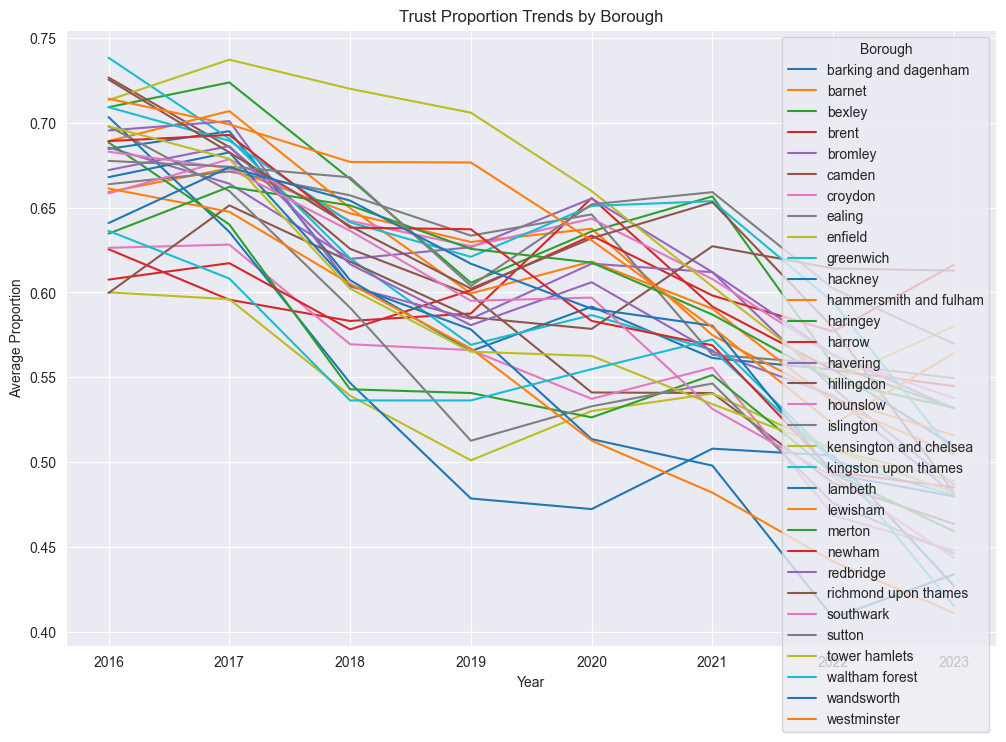

In [19]:

import matplotlib.pyplot as plt
import pandas as pd

# Assume `pas` is preloaded as a DataFrame
fig, ax = plt.subplots(figsize=(12, 8))
for borough in pas['borough'].unique():
    borough_data = pas[pas['borough'] == borough]
    borough_data.groupby('Year')['Proportion'].mean().plot(ax=ax, label=borough)

ax.set_title('Trust Proportion Trends by Borough')
ax.set_xlabel('Year')
ax.set_ylabel('Average Proportion')
ax.legend(title='Borough')
plt.show()


In [21]:
median_values = pas.groupby('borough')['Proportion'].median()
ymax = median_values.max()
ymin = median_values.min()

print(ymax)


0.745


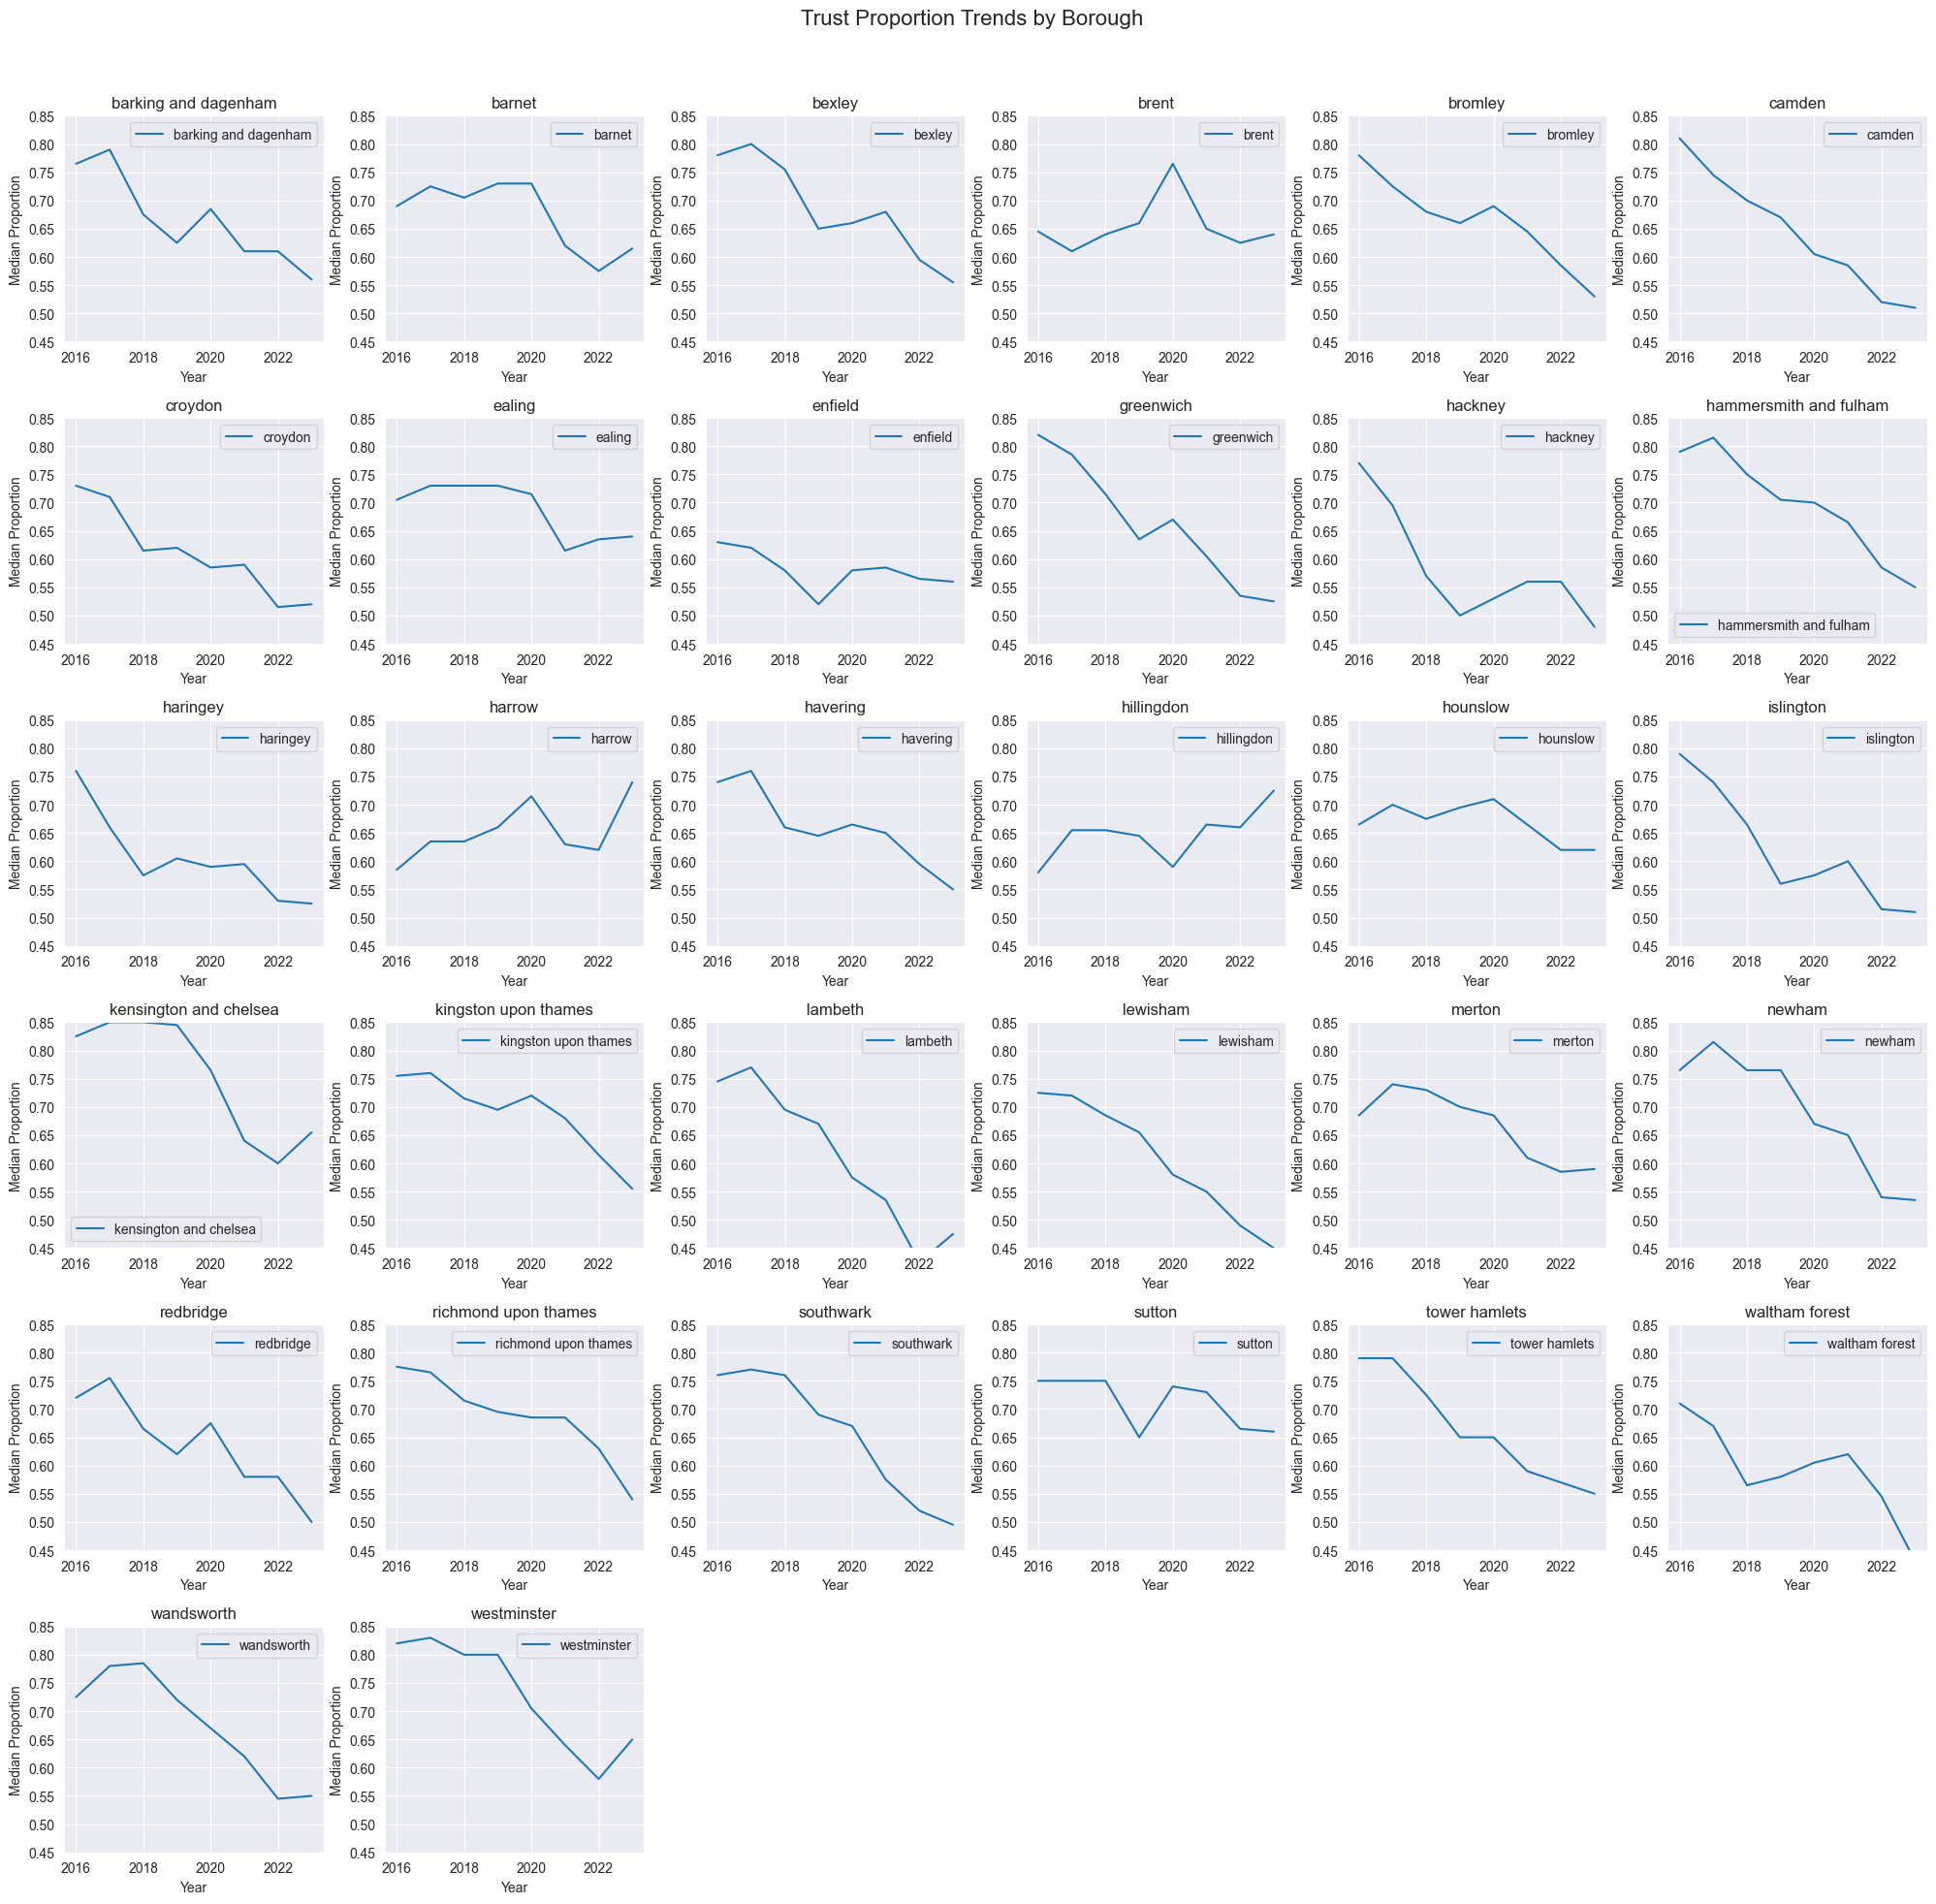

In [23]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming `combined_agg` is preloaded as a DataFrame and includes the 'Proportion', 'Year', and 'borough' columns

boroughs = pas['borough'].unique()
num_boroughs = len(boroughs)

# Calculate the number of rows and columns for the subplots grid
cols = 6  # You can adjust the number of columns
rows = (num_boroughs // cols) + (num_boroughs % cols > 0)
median_values = pas.groupby('borough')['Proportion'].median()
ymax = median_values.max()
ymin = median_values.min()

fig, axes = plt.subplots(rows, cols, figsize=(20, 20))
fig.suptitle('Trust Proportion Trends by Borough', fontsize=16)

# Flatten axes array for easy iteration
axes = axes.flatten()

for i, borough in enumerate(boroughs):
    borough_data = pas[pas['borough'] == borough]
    borough_data.groupby('Year')['Proportion'].median().plot(ax=axes[i], label=borough)
    axes[i].set_title(borough)
    axes[i].set_xlabel('Year')
    axes[i].set_ylabel('Median Proportion')
    axes[i].legend()
        # Set the same y-axis limits for all plots
    axes[i].set_ylim(0.45, 0.85)

# Remove any empty subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()




## Linear Regression of Pas & Stop&Search (predicting proportion)

Combine the 2 datasets

In [24]:
# Merge the datasets on 'borough', 'Year', and 'Month'
combined_data = pd.merge(pas, stop_and_search_df, on=['borough', 'Year', 'Month'], how='inner')



#CONSIDER AGGREGATING

# # Aggregating Stop and Search data by outcome counts
# agg_stop_search = stop_and_search_df.groupby(['borough', 'Year', 'Month']).agg({
#     'outcome': pd.Series.value_counts
# }).unstack(fill_value=0).reset_index()
# 
# # Merge aggregated data with PAS
# combined_data_agg = pd.merge(pas, agg_stop_search, on=['borough', 'Year', 'Month'], how='inner')



Filter both datasets to include only overlapping sets

Combine dataframes (Consider Implementing)

How to separate Trust and Confidence:
Trust - Trust MPS , Contact ward officer , Listen to concerns , Treat everyone fairly
Confidence - Good Job Local, Understand issues , Relied on to be there, Informed local 

Encode outcome variable & Merge the pas with stop & search

In [25]:
# One-hot encode the 'outcome' variable
outcome_dummies = pd.get_dummies(stop_and_search_df['outcome'], prefix='outcome')
stop_and_search_df_encoded = pd.concat([stop_and_search_df.drop('outcome', axis=1), outcome_dummies], axis=1)

# Aggregate these outcomes by counting occurrences of each outcome type per borough-month
outcome_counts = stop_and_search_df_encoded.groupby(['borough', 'Year', 'Month']).sum().reset_index()

# Merge this aggregated data back with the PAS data
combined_agg = pd.merge(pas, outcome_counts, on=['borough', 'Year', 'Month'], how='inner')


Below you can find: combined_agg.columns


In [ ]:
# Index(['Survey', 'borough', 'Measure', 'Proportion', 'MPS', 'Year', 'Month',
#        'type', 'part_of_a_policing_operation', 'latitude', 'longitude',
#        'gender', 'age_range', 'self_defined_ethnicity',
#        'officer_defined_ethnicity', 'legislation', 'object_of_search',
#        'outcome_a no further action disposal', 'outcome_arrest',
#        'outcome_article found - detailed outcome unavailable',
#        'outcome_caution (simple or conditional)',
#        'outcome_community resolution', 'outcome_khat or cannabis warning',
#        'outcome_local resolution', 'outcome_nothing found - no further action',
#        'outcome_offender cautioned',
#        'outcome_offender given drugs possession warning',
#        'outcome_offender given penalty notice',
#        'outcome_penalty notice for disorder',
#        'outcome_summons / charged by post', 'outcome_suspect arrested',
#        'outcome_suspect summonsed to court'],
#       dtype='object')

In [27]:

       
       
import statsmodels.api as sm


selected_outcomes = [
    'outcome_a no further action disposal', 'outcome_arrest',
       'outcome_article found - detailed outcome unavailable',
       'outcome_caution (simple or conditional)',
       'outcome_community resolution', 'outcome_khat or cannabis warning',
       'outcome_local resolution', 'outcome_nothing found - no further action',
       'outcome_offender cautioned',
       'outcome_offender given drugs possession warning',
       'outcome_offender given penalty notice',
       'outcome_penalty notice for disorder',
       'outcome_summons / charged by post', 'outcome_suspect arrested',
       'outcome_suspect summonsed to court'
]

# Prepare the independent variables (outcomes) and add a constant term for intercept
# X = combined_agg.drop(columns=['Survey', 'Measure', 'Proportion', 'MPS', 'borough', 'Year', 'Month'])
X = combined_agg[selected_outcomes]
X = sm.add_constant(X)  # adding a constant


#  dependent variable
y = combined_agg['Proportion']

# Fit  model
model = sm.OLS(y, X).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:             Proportion   R-squared:                       0.047
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     25.42
Date:                Mon, 27 May 2024   Prob (F-statistic):           3.96e-70
Time:                        19:02:28   Log-Likelihood:                 1466.7
No. Observations:                7768   AIC:                            -2901.
Df Residuals:                    7752   BIC:                            -2790.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                                           coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------

Check if you can compute R2 for sarimax

In [26]:
print(len(set(pas['borough'].values)))

32


## Important Think about using legislation and object of search

## AR & ARIMA models for our datasets

Survey  borough             Measure  Proportion   MPS  \
Year Month                                                         
2016 6        PAS   barnet    "Good Job" local        0.67  0.69   
     6        PAS   bexley    "Good Job" local        0.74  0.69   
     6        PAS    brent    "Good Job" local        0.62  0.69   
     6        PAS  bromley    "Good Job" local        0.69  0.69   
     6        PAS   camden    "Good Job" local        0.69  0.69   
...           ...      ...                 ...         ...   ...   
     6        PAS    brent  Listen to concerns        0.66  0.74   
     6        PAS  bromley  Listen to concerns        0.77  0.74   
     6        PAS   camden  Listen to concerns        0.82  0.74   
     6        PAS  croydon  Listen to concerns        0.74  0.74   
     6        PAS   ealing  Listen to concerns        0.71  0.74   

                                                         type  \
Year Month                                                      
2016 6      person and vehicle searchperson and vehicle se...   
     6      person and vehicle searchperson searchperson s...   
     6      person searchperson and vehicle searchperson s...   
     6      person searchperson searchperson searchperson ...   
     6      person searchperson searchperson searchperson ...   
...                                                       ...   
     6      person searchperson and vehicle searchperson s...   
     6      person searchperson searchperson searchperson ...   
     6      person searchperson searchperson searchperson ...   
     6      person searchperson searchperson searchperson ...   
     6      person and vehicle searchperson and vehicle se...   

                                 part_of_a_policing_operation      latitude  \
Year Month                                                                    
2016 6      0.00.00.00.00.00.00.00.00.00.00.00.00.00.00.00...   8773.008769   
     6      0.00.00.00.00.00.00.00.00.00.00.00.00.00.00.00...   4477.119197   
     6      0.00.00.00.00.00.00.00.00.00.00.00.00.00.00.00...  34487.316558   
     6      0.00.00.00.00.00.00.00.00.00.00.00.00.00.00.00...  12747.695415   
     6      0.00.00.00.00.00.00.00.00.00.00.00.00.00.00.00...  18089.593005   
...                                                       ...           ...   
     6      0.00.00.00.00.00.00.00.00.00.00.00.00.00.00.00...  34487.316558   
     6      0.00.00.00.00.00.00.00.00.00.00.00.00.00.00.00...  12747.695415   
     6      0.00.00.00.00.00.00.00.00.00.00.00.00.00.00.00...  18089.593005   
     6      0.00.00.00.00.00.00.00.00.00.00.00.00.00.00.00...  10943.783451   
     6      0.00.00.00.00.00.00.00.00.00.00.00.00.00.00.00...  12415.389846   

             longitude                                             gender  \
Year Month                                                                  
2016 6      -36.910779  malemalemalemalemalemalemalemalemalemalemalema...   
     6       12.037471  malemalemalemalemalemalemalefemalefemalefemale...   
     6     -173.602749  malemalemalemalemalemalemalemalemalemalemalema...   
     6        3.177743  malemalemalemalemalemalemalemalemalemalemalema...   
     6      -49.590342  malemalemalemalemalemalemalemalemalemalemalema...   
...                ...                                                ...   
     6     -173.602749  malemalemalemalemalemalemalemalemalemalemalema...   
     6        3.177743  malemalemalemalemalemalemalemalemalemalemalema...   
     6      -49.590342  malemalemalemalemalemalemalemalemalemalemalema...   
     6      -20.912920  malemalemalemalemalemalemalemalemalemalemalema...   
     6      -80.616878  malemalemalemalemalemalemalemalemalemalemalema...   

            ... outcome_khat or cannabis warning_lag_1  \
Year Month  ...                                          
2016 6      ...                                    0.0   
     6      ...                                    0.0   
     6      ...   

(7767, 30)
(7767,)
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 7767 entries, (2016, 6) to (2023, 12)
Data columns (total 30 columns):
 #   Column                                                      Non-Null Count  Dtype  
---  ------                                                      --------------  -----  
 0   outcome_a no further action disposal                        7767 non-null   int64  
 1   outcome_arrest                                              7767 non-null   int64  
 2   outcome_article found - detailed outcome unavailable        7767 non-null   int64  
 3   outcome_caution (simple or conditional)                     7767 non-null   int64  
 4   outcome_community resolution                                7767 non-null   int64  
 5   outcome_khat or cannabis warning                            7767 non-null   int64  
 6   outcome_local resolution                                    7767 non-null   int64  
 7   outcome_nothing found - no further action             

/Users/cris/PycharmProjects/JBG040-Group15/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


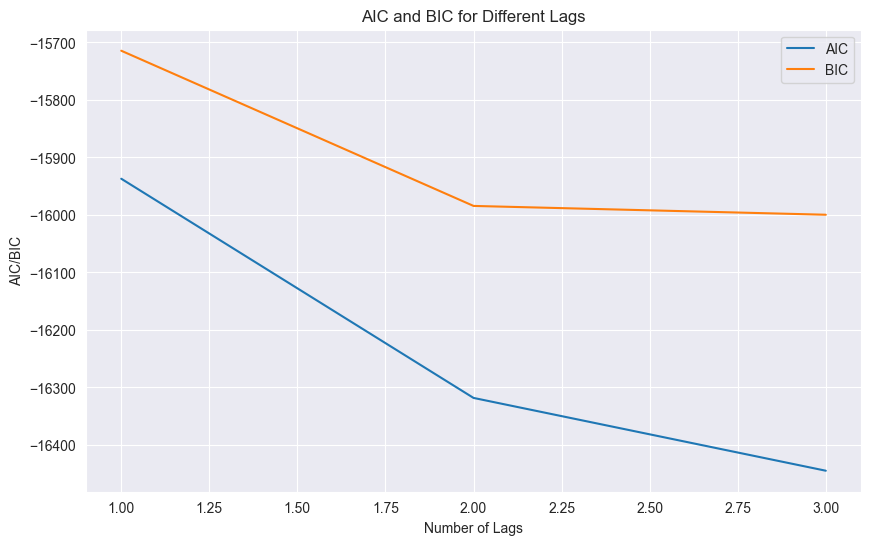

Optimal number of lags: 3
outcome_a no further action disposal                            int64
outcome_arrest                                                  int64
outcome_article found - detailed outcome unavailable            int64
outcome_caution (simple or conditional)                         int64
outcome_community resolution                                    int64
outcome_khat or cannabis warning                                int64
outcome_local resolution                                        int64
outcome_nothing found - no further action                       int64
outcome_offender cautioned                                      int64
outcome_offender given drugs possession warning                 int64
outcome_offender given penalty notice                           int64
outcome_penalty notice for disorder                             int64
outcome_summons / charged by post                               int64
outcome_suspect arrested                                        

/Users/cris/PycharmProjects/JBG040-Group15/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 6212
Model:               SARIMAX(3, 1, 0)   Log Likelihood                6621.547
Date:                Mon, 27 May 2024   AIC                         -13115.094
Time:                        19:10:02   BIC                         -12684.144
Sample:                             0   HQIC                        -12965.695
                               - 6212                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1         -4.382e-05   1.92e-05     -2.279      0.023   -8.15e-05   -6.14e-06
x2            -0.0005   7.99e-05     -6.062      0.000      -0.001      -0.000
x3             0.0176      0.008      2.215      0.0

In [28]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

# Assuming combined_agg is the merged dataset from previous steps
combined_agg.set_index(['Year', 'Month'], inplace=True)

#Dropping MPS to be sure
combined_agg.drop(columns='MPS')

# Focus on the Proportion column (trust level) for ARIMAX models
trust_series = combined_agg['Proportion']

# Selected outcomes to include as lagged variables
selected_outcomes = [
    'outcome_a no further action disposal', 'outcome_arrest',
    'outcome_article found - detailed outcome unavailable',
    'outcome_caution (simple or conditional)',
    'outcome_community resolution', 'outcome_khat or cannabis warning',
    'outcome_local resolution', 'outcome_nothing found - no further action',
    'outcome_offender cautioned',
    'outcome_offender given drugs possession warning',
    'outcome_offender given penalty notice',
    'outcome_penalty notice for disorder',
    'outcome_summons / charged by post', 'outcome_suspect arrested',
    'outcome_suspect summonsed to court'
]

# Create lagged features for the selected outcomes and trust_series
def create_lagged_features(df, lags):
    lagged_df = df.copy()
    for lag in range(1, lags + 1):
        lagged_df[f'Proportion_lag_{lag}'] = df['Proportion'].shift(lag)
        for outcome in selected_outcomes:
            lagged_df[f'{outcome}_lag_{lag}'] = df[outcome].shift(lag)
    return lagged_df

# Determine the optimal number of lags using AIC/BIC
aic_values = []
bic_values = []
lags_range = range(1, 4)  # Example: test lags from 1 to 3 months

for lag in lags_range:
    lagged_data = create_lagged_features(combined_agg, lag).dropna()
    y = lagged_data['Proportion']
    X = lagged_data.drop(columns=['Proportion'] +['MPS'] + ['latitude'] +['longitude'] + [f'Proportion_lag_{i}' for i in range(1, lag + 1)])
    # Remove non-numeric columns
    X = X.select_dtypes(include=[np.number])
    
    
    print(X.shape)
    print(y.shape)
    print(X.info(verbose=True))
    
    # Convert data to numpy arrays
    y = np.asarray(y).astype(np.float64)
    X = np.asarray(X).astype(np.float64)
    
    # Fit SARIMAX model
    model = SARIMAX(y, exog=X, order=(lag, 1, 0), enforce_stationarity=False, enforce_invertibility=False)
    results = model.fit(disp=False)
    
    aic_values.append(results.aic)
    bic_values.append(results.bic)

# Plotting AIC and BIC
plt.figure(figsize=(10, 6))
plt.plot(lags_range, aic_values, label='AIC')
plt.plot(lags_range, bic_values, label='BIC')
plt.xlabel('Number of Lags')
plt.ylabel('AIC/BIC')
plt.title('AIC and BIC for Different Lags')
plt.legend()
plt.show()

# Selecting the optimal number of lags based on the minimum AIC/BIC
optimal_lag = lags_range[aic_values.index(min(aic_values))]
print(f'Optimal number of lags: {optimal_lag}')

# Create the final lagged dataset with optimal lags
lagged_data = create_lagged_features(combined_agg, optimal_lag).dropna()
y = lagged_data['Proportion']
X = lagged_data.drop(columns=['Proportion'] +['MPS'] + ['latitude'] + ['longitude']+ [f'Proportion_lag_{i}' for i in range(1, optimal_lag + 1)])
X = X.select_dtypes(include=[np.number])

print(X.dtypes)

# Splitting the data into train and test sets
train_size = int(len(y) * 0.8)
y_train, y_test = y[:train_size], y[train_size:]
X_train, X_test = X[:train_size], X[train_size:]

# Convert data to numpy arrays
y_train = np.asarray(y_train).astype(np.float64)
X_train = np.asarray(X_train).astype(np.float64)
y_test = np.asarray(y_test).astype(np.float64)
X_test = np.asarray(X_test).astype(np.float64)

# Fit final SARIMAX model with optimal lags
final_model = SARIMAX(y_train, exog=X_train, order=(optimal_lag, 1, 0), enforce_stationarity=False, enforce_invertibility=False)
final_results = final_model.fit(disp=False)
print(final_results.summary())

# Making predictions with exogenous variables
predictions = final_results.predict(start=len(y_train), end=len(y_train)+len(y_test)-1, exog=X_test, dynamic=False)

# Evaluating the model
mse = mean_squared_error(y_test, predictions)
print(f'Final SARIMAX Model MSE: {mse}')


## VAR Model

We first need to run the combined agg thing

In [29]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Merge this aggregated data back with the PAS data
combined_agg = pd.merge(pas, outcome_counts, on=['borough', 'Year', 'Month'], how='inner')


# Assuming combined_agg is the merged dataset from previous steps
combined_agg.set_index(['Year', 'Month'], inplace=True)

# Create a datetime index from the 'Year' and 'Month' MultiIndex
combined_agg.index = pd.to_datetime(combined_agg.index.map(lambda x: f'{x[0]}-{x[1]:02d}'))




selected_outcomes = [
    'outcome_a no further action disposal', 'outcome_arrest',
    'outcome_article found - detailed outcome unavailable',
    'outcome_caution (simple or conditional)',
    'outcome_community resolution', 'outcome_khat or cannabis warning',
    'outcome_local resolution', 'outcome_nothing found - no further action',
    'outcome_offender cautioned',
    'outcome_offender given drugs possession warning',
    'outcome_offender given penalty notice',
    'outcome_penalty notice for disorder',
    'outcome_summons / charged by post', 'outcome_suspect arrested',
    'outcome_suspect summonsed to court'
]

# Select relevant columns for the VAR model
columns = ['Proportion'] + selected_outcomes
data = combined_agg[columns].dropna()

# Fit VAR model
model = VAR(data)
lag_order = model.select_order(maxlags=8)

# Fit the model with the optimal lag order
var_model = model.fit(lag_order.aic)

# Forecasting
# Predicting the next 2 steps
forecast_steps = 4
forecast = var_model.forecast(data.values[-lag_order.aic:], steps=forecast_steps)
forecast_index = pd.date_range(start=data.index[-1], periods=forecast_steps, freq='MS')
forecast_df = pd.DataFrame(forecast, index=forecast_index, columns=columns)
# Evaluate the model
# Split the data into train and test sets
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

# Fit the model on the training data
var_model_train = model.fit(lag_order.aic)

# Forecast on the test data
forecast_test = var_model_train.forecast(train.values[-lag_order.aic:], steps=len(test))
forecast_test_df = pd.DataFrame(forecast_test, index=test.index, columns=columns)

# Calculate MSE
mse = mean_squared_error(test['Proportion'], forecast_test_df['Proportion'])
print(f'VAR Model MSE: {mse}')


/Users/cris/PycharmProjects/JBG040-Group15/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/cris/PycharmProjects/JBG040-Group15/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


VAR Model MSE: 0.039210486366145325


## Correlation Matrix

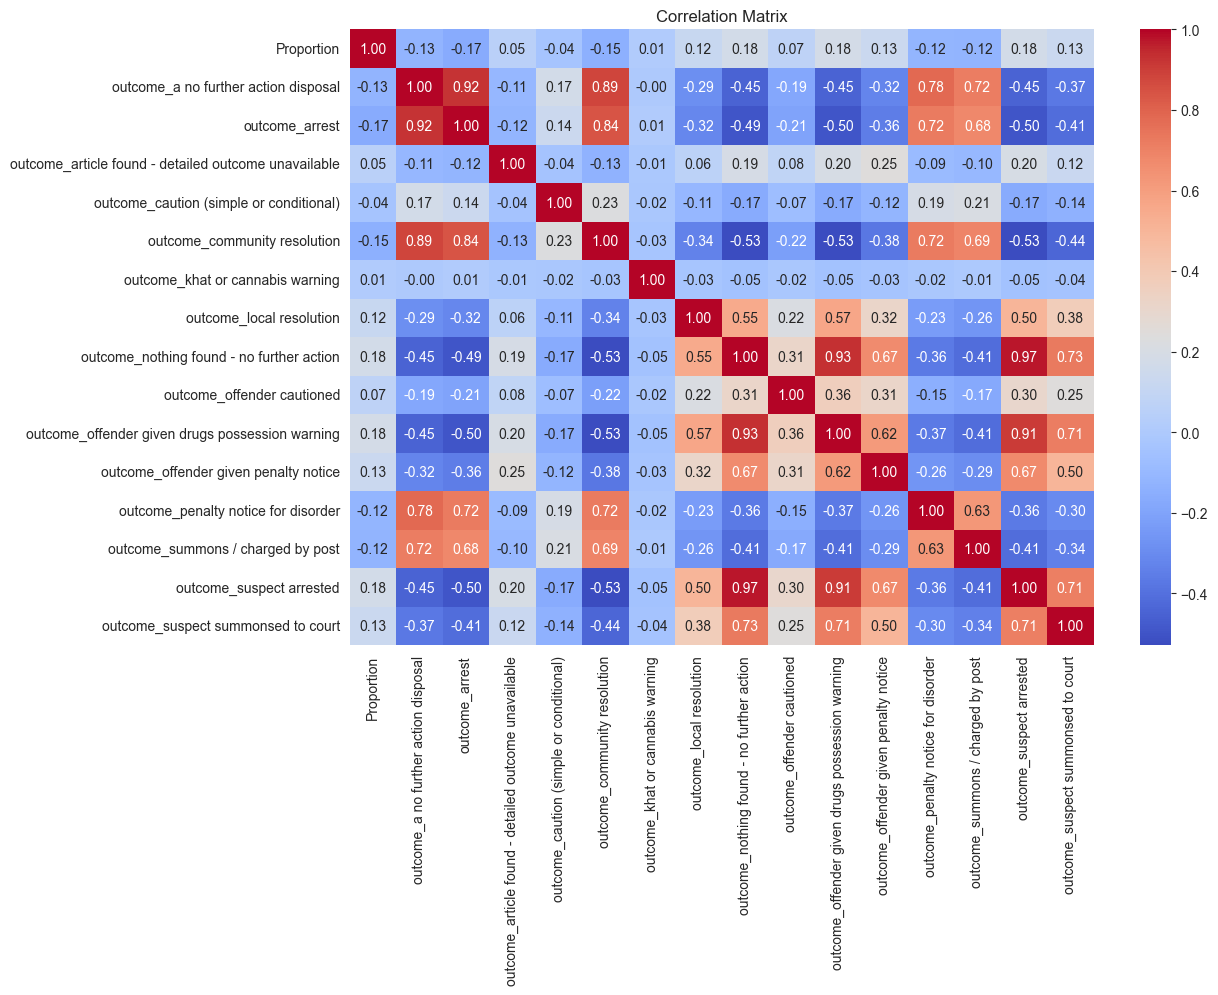

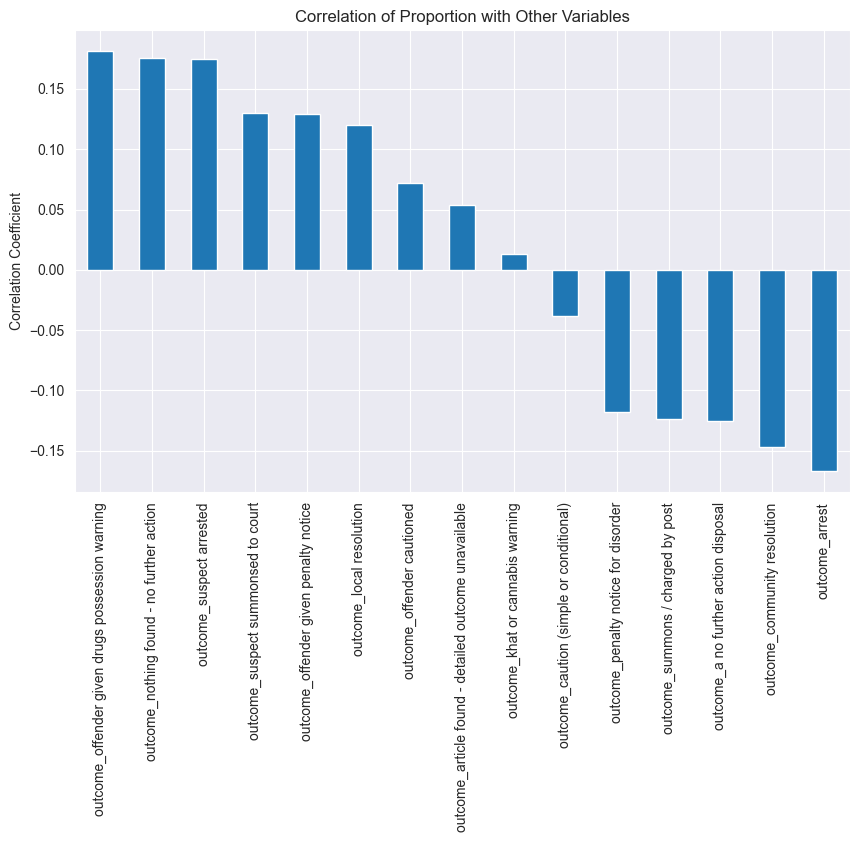

Proportion                                              1.000000
outcome_offender given drugs possession warning         0.181131
outcome_nothing found - no further action               0.175296
outcome_suspect arrested                                0.175173
outcome_suspect summonsed to court                      0.129871
outcome_offender given penalty notice                   0.129210
outcome_local resolution                                0.119981
outcome_offender cautioned                              0.071640
outcome_article found - detailed outcome unavailable    0.053592
outcome_khat or cannabis warning                        0.013006
outcome_caution (simple or conditional)                -0.037930
outcome_penalty notice for disorder                    -0.117658
outcome_summons / charged by post                      -0.123315
outcome_a no further action disposal                   -0.125580
outcome_community resolution                           -0.146495
outcome_arrest           

In [172]:
import seaborn as sns

combined_agg = pd.merge(pas, outcome_counts, on=['borough', 'Year', 'Month'], how='inner')
combined_agg = combined_agg.select_dtypes(include=[np.number])

combined_agg = combined_agg.drop(columns=['Year']+['Month'] +['MPS'] + ['latitude'] +['longitude'])


# Calculate the correlation matrix
corr_matrix = combined_agg.corr()



# Extract the correlation of 'Proportion' with other variables
proportion_corr = corr_matrix['Proportion'].sort_values(ascending=False)

# Plotting the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Plotting correlation of 'Proportion' with other variables
plt.figure(figsize=(10, 6))
proportion_corr.drop('Proportion').plot(kind='bar')
plt.title('Correlation of Proportion with Other Variables')
plt.ylabel('Correlation Coefficient')
plt.show()

print(proportion_corr)
